In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/workout-image-classfication-dataset/Workout_image_classification/val/t bar row/t bar row_700241.jpg
/kaggle/input/workout-image-classfication-dataset/Workout_image_classification/val/t bar row/t bar row_2000181.jpg
/kaggle/input/workout-image-classfication-dataset/Workout_image_classification/val/t bar row/t bar row_700111.jpg
/kaggle/input/workout-image-classfication-dataset/Workout_image_classification/val/t bar row/t bar row_1000071.jpg
/kaggle/input/workout-image-classfication-dataset/Workout_image_classification/val/t bar row/t bar row_1000061.jpg
/kaggle/input/workout-image-classfication-dataset/Workout_image_classification/val/t bar row/t bar row_2000191.jpg
/kaggle/input/workout-image-classfication-dataset/Workout_image_classification/val/t bar row/t bar row_2000541.jpg
/kaggle/input/workout-image-classfication-dataset/Workout_image_classification/val/t bar row/t bar row_100061.jpg
/kaggle/input/workout-image-classfication-dataset/Workout_image_classification/val/

In [2]:
!pip install torchvision

In [3]:
import torch
import torch.nn as nn
import torch .optim as optim
from torchvision import datasets, transforms, models
import os

import warnings
warnings.filterwarnings('ignore')

In [4]:
#Define data transformations for data augmentation and normalizations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),#first resizes the image to a random size of 224x224 pixels and then takes a random crop from it
        transforms.RandomHorizontalFlip(),#This transformation randomly flips the input image horizontally with a probability of 0.5
        transforms.ToTensor(),# transform the input image into tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the tansor image
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),# This transformation resizes the input image to a fixed size of 256x256 pixels
        transforms.CenterCrop(224), # After resizing the image to 256x256, this transformation crops the center region of the image to obtain a size of 224x224 pixels
        transforms.ToTensor(),# transform the input image into tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the tansor image
    ])
}

In [5]:
#define the data directory
data_dir = '//kaggle//input//workout-image-classfication-dataset//Workout_image_classification'

#Create data loaders
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','val']}

In [6]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=50, shuffle=True, num_workers=4) for x in ['train','val']}
# batch size specifies the no. of samples in each batch that will be returned in each iteration of the data loader .
# num_workers specifies the number of subprocesses to use for data loading
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
print('dataset_sizes:',dataset_sizes)

class_names = image_datasets['train'].classes
class_names

dataset_sizes: {'train': 11074, 'val': 1375}


['barbell biceps curl',
 'bench press',
 'chest fly machine',
 'deadlift',
 'decline bench press',
 'hammer curl',
 'hip thrust',
 'incline bench press',
 'lat pulldown',
 'lateral raises',
 'leg extension',
 'leg raises',
 'plank',
 'pull up',
 'push up',
 'romanian deadlift',
 'russian twist',
 'shoulder press',
 'squat',
 't bar row',
 'tricep dips',
 'tricep pushdown']

In [7]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if 'fc' in name: # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False
#If the parameter belongs to the final fc layer, it sets requires_grad to True, meaning the parameter will be updated during training else not updated during training.

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)
# SGD : Stochastic Gradient Descent

# Move to the model to the GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#If available, it sets the device to "cuda:0"; otherwise, it sets it to "cpu".
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s] 


In [8]:
# training loop
num_epochs = 20
for epoch in range(num_epochs):
    for phase in ['train','val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
            
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            # Clears the gradients of all optimized parameters
            
            with torch.set_grad_enabled(phase == 'train'):
            #  Enables gradient calculation during training phase and disables it during validation phase
                outputs = model(inputs)
            # extracts the predicted class labels from the model's output probabilities (outputs) and stores them in the variable preds. 
            # The torch.max() function is a convenient way to perform this operation in PyTorch.
                _,preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                #Computes the loss between the model predictions and the ground truth labels
                
                if phase == 'train':
                    loss.backward() # Computes gradients of the loss with respect to model parameters.
                    optimizer.step() #  Updates the model parameters based on the computed gradients and the optimization algorithm
                    
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
        print(f'{phase} loss: {epoch_loss: .4f} Acc: {epoch_acc: .4f}')
    
print('Training complete')                

train loss:  4.0231 Acc:  0.1522
val loss:  2.1730 Acc:  0.3796
train loss:  2.1044 Acc:  0.4032
val loss:  1.4012 Acc:  0.6000
train loss:  1.6212 Acc:  0.5334
val loss:  1.0347 Acc:  0.7120
train loss:  1.3562 Acc:  0.6136
val loss:  0.8395 Acc:  0.7622
train loss:  1.1941 Acc:  0.6632
val loss:  0.6970 Acc:  0.8109
train loss:  1.0878 Acc:  0.6876
val loss:  0.6224 Acc:  0.8364
train loss:  0.9850 Acc:  0.7220
val loss:  0.5521 Acc:  0.8582
train loss:  0.9447 Acc:  0.7349
val loss:  0.4949 Acc:  0.8735
train loss:  0.8805 Acc:  0.7515
val loss:  0.4594 Acc:  0.8756
train loss:  0.8457 Acc:  0.7638
val loss:  0.4257 Acc:  0.8829
train loss:  0.8099 Acc:  0.7735
val loss:  0.4044 Acc:  0.8945
train loss:  0.7805 Acc:  0.7854
val loss:  0.3723 Acc:  0.9062
train loss:  0.7556 Acc:  0.7885
val loss:  0.3582 Acc:  0.9084
train loss:  0.7151 Acc:  0.8036
val loss:  0.3430 Acc:  0.9120
train loss:  0.7118 Acc:  0.8031
val loss:  0.3227 Acc:  0.9207
train loss:  0.7050 Acc:  0.8095
val los

In [14]:
# save the model
torch.save(model.state_dict(),'//kaggle//working//workout_classification_model.pth')

## Classification on Unseen Image

*To use the saved model to classify unseen images, you need to load the model and then apply it to the new images for inference*

In [16]:
from PIL import Image #  used for image manipulation

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000) 
# adjust to match the original model's output units
model.load_state_dict(torch.load('//kaggle//working//workout_classification_model.pth'))
# load the model
model.eval()

# Create a new model with correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 22)
# no of outout equals to no of classes in classification model
# Adjust to match the desired output units

# copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:22]
new_model.fc.bias.data = model.fc.bias.data[0:22]

*Prepare new image for classification. You should use the same data transformations you used traing. Here's an example of how to prepare an image for inference:*

In [24]:
# Looad and preprocess the unseen image
image_path = '//kaggle//input//random-test1//random_test1.jpg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

# unsqueeze(0) adds a new dimension to the tensor at the specified position (0 in this case).
# This line creates a batch of input tensors by adding a batch dimension to the preprocessed tensor.
# The resulting input_batch tensor has a shape of [1, C, H, W], where:
# 1 represents the batch size (in this case, there's only one input image).
# C is the number of channels in the image (e.g., 3 for RGB images).
# H is the height of the image.
# W is the width of the image.

**Perform inference using the model**

In [25]:
# Perfrom inference
with torch.no_grad():
    #  This context manager temporarily disables gradient calculation, 
    # which reduces memory usage and speeds up computation during inference (when no backpropagation is needed)
    output = model(input_batch)
    
# Get the predicted class
_, predicted_class = output.max(1)
# This line calculates the predicted class by finding the index (position) of the maximum value along dimension 1 of the output tensor (output). 
# The max(1) function returns both the maximum values and their corresponding indices.

# Map the predicted class to the class name
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: lateral raises


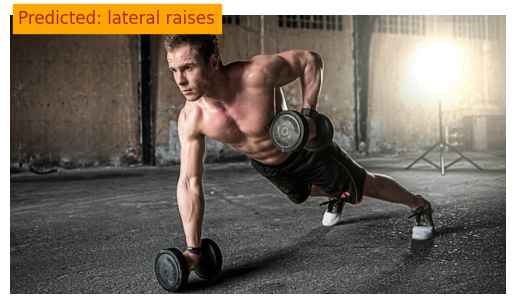

In [26]:
import matplotlib.pyplot as plt

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10,10,f'Predicted: {predicted_class_name}', fontsize=12, color = 'brown', backgroundcolor='orange')
plt.show()